# Modélisation d'un système de Lennard-Jones en deux dimensions, calcul de diagramme de phase

Côme Cattin, M1 SdM ENS Lyon, 2022

Code diponible sur GitHub : https://github.com/sequoia-dev/Phase_Diagram_LJ

## Introduction

Le but de ce projet est de modeliser un système de Lennard-Jones en deux dimensions à différentes températures et densités afin d'obtenir son diagramme de phase. Nous nous sommes basés principalement sur les routines déjà existantes et fournies en cours ansi qu'en TD

## Le système

Le système que nous allons modélisé est un système de Lennard-Jones : les particules le composant sont régies par le potentiel de Lennard-Jones :

\begin{equation}
U_{LJ}(r) = 4\epsilon \left(\left(\frac\sigma{r}\right)^{12} - \left(\frac\sigma{r}\right)^6 \right)
\end{equation}

où $\epsilon = 1$, $\sigma = 1$ et $r$ est la distance entre deux particules du système.

Nos modelisations porteront, sauf mention contraire, sur un système à 16 particules, en deux dimensions

In [25]:
#Dimension
d=2
#Number of particles
NParticles=16

# Lennard-Jones
sigma = 1
epsilon = 1

Aussi notre étude est restreinte à une zone particulière du diagramme de phase :

\begin{equation}
kT \in [0.3;1]\\
\rho \in [0.05;0.8]
\end{equation}

avec $k$ la constante de Boltzmann, $T$ la température et $\rho$ la densité.

## Implémentation

Un certains nombre de bibliothèques sont nécessaire à notre étude

In [27]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

Afin d'établir quantitativement la phase du système, nous avons tout d'abbord décidé de mesurer la compressibilité du système pour chaque zone du diagramme de phase. Nous utilisons pour cela la fonction `Generate_LJ_NVT_MolecularDynamics_Trajectory`

**L'entièreté des codes suivants est diponible dans les fichiers `multi_processing.py`et `projet.py`**

## Compressibilité

### Première version, non optimisée

Une première approche, non pas la plus efficace, est d'estimer la compressibilité à chaque paramètre du système et cela tour à tour, avec  ainsi deux boucles `for`

In [28]:
def phase_diagram_compressibility(d,NParticles,sigma,epsilon,kT,rho):
    """
    'Naive' version of the phase diagram computation.
    
    Parameters
    ----------
    d : int
        System dimension.
    NParticles : int
        Number of particles in the system.
    sigma : float
        Sigma parameter in the LJ system.
    epsilon : float
        Epsilon parameter in the LJ system.
    kT : iterable of float
        Temperatures at which the system is to be computed.
    rho : iterable of float
        Density at which the system is to be computed.
    
    Returns
    ----------
    compressibility : array
        Compressibility of the system for every couple of rho and kT.
    """
    
    #Mass of particles in the system
    m = np.ones(NParticles)
    
    #unit of time 
    tau = sigma*np.sqrt(m[0]/epsilon)    

    # define the length of the trajectory
    run_time = 100. * tau
    
    #Box size
    LBox = np.power(NParticles/rho,1./d)
    
    #Initialization of the compressibility
    compressibility = np.zeros((kT.shape[0],LBox.shape[0]))

    #For every box length
    for i, LBox_i in enumerate(LBox):
        #For every temperature
        for j, kT_j in enumerate(kT):
            
            #Get particles trajectories via the routine 
            ( t_tr, x_tr, y_tr, 
             vx_tr, vy_tr, 
             uPot_tr, uKin_tr, 
             pPot_tr, pKin_tr, 
             pHyper_tr, 
             [t,x,y,vx,vy]) = MD.Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,
                                                                              LBox_i,
                                                                              kT_j,
                                                                              run_time,
                                                                              number_of_time_steps_between_stored_configurations=1)
            #Compute the compressibility via the routine and store it in an array
            compressibility[i,j] = MD.Compressibility_from_pressure_fluctuations_in_NVT(d,m,
                                                                                        NParticles,
                                                                                        LBox_i,
                                                                                        kT_j,
                                                                                        pPot_tr, 
                                                                                        pHyper_tr, 
                                                                                        pKin_tr)

    #Plot
    plt.imshow(compressibility,extent=(0.8,0.05,0.3,5),aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('Compressibility')
    plt.xlabel('$rho$')
    plt.ylabel('$kT$')
    plt.title('Phase diagram')
    #plt.savefig('phase_diagramm.png')
    
    return compressibility
    

Ce programme étant assez peu efficace, nous réduisons la taille du nombre de calcul effectués.

In [29]:
#Calcul sur un diagramme de taille (5x5)
kT = np.linspace(0.3,1,5)
rho  = np.linspace(0.05,0.8,5)/sigma**d

Time to execute :  277.42178160000003


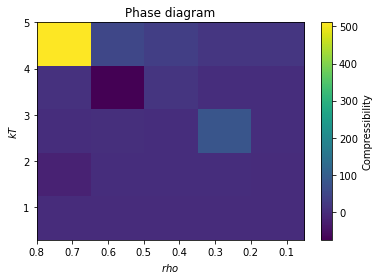

In [30]:
init_time = time.perf_counter()
compressibility = phase_diagram_compressibility(d,NParticles,sigma,epsilon,kT,rho)

print('Time to execute : ',time.perf_counter()-init_time)

Nous observons deux choses dans ces résulats :
- Déjà le temps de calcul est très long (~4min30sec sur ma machine) pour un diagramme de phase avec seulement une résolution 5x5, un temps laissé à la simulation de `100*tau` et 16 particules. Dans l'optique de réaliser un ensemble de simulations identiques afin d'obtenir une estimation de l'erreur commise nous devons optimiser notre fonction.
- Le résultat physique n'est pas convainquant. En effet, des compressibilités négatives sont obtenues. Ensuite, pour certains couple $(rho,kT)$ les valeurs absolues de la compressibilité obtenues sont largement au dessus des autres, "noyant" ainsi les résultats.

Peut-être ne nous laissons pas suffisement de temps à la simulation et ainsi mesurons nous avant l'état d'équilibre ?

Pour le vérifier, nous devons augmenter le temps de simulation, ainsi le temps de calcul. Nous devons alors optimiser de notre fonction.

### Parallelisation

Notre fonction étant principalement composée de deux boucles `for` imbriquées et chaque résultat de cette boucle étant indépendant des autres, une parallelisation de notre code semble être une bonne solution pour résoudre ce problème de temps de calcul. Pour distribuer sur plusieurs coeurs notre routine, nous utiliserons la bibliothèque `multiprocessing` de Python.

In [31]:
import multiprocessing as mp
#Nous avons également besoin de la bibliothèque itertools
#afin d'obtenir l'ensemble des couples de kT et rho possibles
import itertools

De cette bibliothèque, nous utiliserons l'objet `Pool` pour distribuer nos calculs. De cette objet, par soucis de lisibilité de notre code nous utiliserons sa fonction `map`. Pour être plus précis, comme notre fonction principale `Generate_LJ_NVT_MolecularDynamics_Trajectory` recquiert plusieurs paramètres, nous utiliserons la fonction `starmap`. Enfin, comme nous souhaitons concatener tous nos résultats dans un tableau, donc dans l'ordre, nous utiliserons cette fonction en version synchrone.

In [32]:
#Nous modifions quelque peu la fonction routine afin que cette dernière soit compatible avec le multiprocessing.

def Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,system,run_time,
                                                 starting_configuration=[],
                                                 time_step = 0.01,
                                                 number_of_time_steps_between_stored_configurations=100,
                                                 number_of_time_steps_between_velocity_resets=100,
                                                 start_from_stable_grid = False,
                                                 debug=False):
    """
    
    MODIFIED FUNCTION FOR MULTIPROSSESSING
    
    
    generates a NVT MD simulations of a LJ system with sigma=epsilon=1  
        - where the particle masses are specified in the array m
        - so that NParticles = m.size
        - in a volume V=(LBox,LBox) at a specified temperature kT
        - with a time step of time_step tau 
          where the LJ unit of time is calculated as a function of m[-1], i.e. the mass of the LAST particle
        - runs are either started from 
                a specified starting configuration [t,x,y,vx,vy] or
                initialized with zero velocities and particles placed on a square grid
        - the simulations are thermostated by redrawing random velocities from the 
          Maxwell-Boltzmann distribution number_of_time_steps_between_velocity_resets time steps
        - the function returns 
                trajectory lists t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr 
                     of sampling times and sampled coordinates, velocities and energies and pressures
                a final configuration [t,x,y,vx,vy] from which the run can be restarted
                while the energies and pressures are recorded at every time step, configurations 
                     and velocities are stored at a time interval of time_between_stored_configurations
                    
    """
    #Added this line to make multiprossessing easier
    LBox, kT = system
    
    NParticles = m.size
    sigma = 1
    epsilon = 1
    #unit of time
    #tau = sigma*np.sqrt(m[-1]/epsilon)      

    # define the length of the trajectory
    number_of_timesteps = int(np.round(run_time/time_step))

    #starting configuration
    if starting_configuration!=[]:
        [t,x,y,vx,vy] = starting_configuration
    else:
        # default initial state
        if start_from_stable_grid:
            x,y = MD.StableGridPositionsIn2d(LBox,LBox,NParticles)
        else:
            x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
        vx = MD.RandomVelocities(m,kT)
        vy = MD.RandomVelocities(m,kT)
        t = 0
        if debug:
            print("No starting configuration")

    #initialize Trajectory
    t_tr = []
    x_tr = []
    vx_tr = []
    y_tr = []
    vy_tr = []

    fx,fy = MD.LJ_forces_as_a_function_of_positions(d,epsilon,sigma,LBox,(x,y))
    # force for initial configuration needed for first time step

    for timestep in range(number_of_timesteps):
        (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartOne(m,(x,y),(vx,vy),(fx,fy),time_step)
        fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
        (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartTwo(m,(x,y),(vx,vy),(fx,fy),time_step)
        t += time_step
        
        t_tr.append(t)
        x_tr.append(x)
        vx_tr.append(vx)
        y_tr.append(y)
        vy_tr.append(vy)
    
        # thermostat: reinitialise velocities to control temperature
#        if np.mod( timestep*time_step, time_between_velocity_resets ) == 0.0 and timestep>1:
        if timestep%number_of_time_steps_between_velocity_resets == 0 and timestep>1:
            vx = MD.RandomVelocities(m,kT)
            vy = MD.RandomVelocities(m,kT)

    # convert trajectory lists to arrays to simplify the data analysis
    t_tr = np.array(t_tr)
    x_tr = np.array(x_tr)
    vx_tr = np.array(vx_tr)
    y_tr = np.array(y_tr)
    vy_tr = np.array(vy_tr)

    # analyse results 
    uPot_tr = MD.LJ_energy_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr))
    uKin_tr = MD.TotalKineticEnergy(m,vx_tr) + MD.TotalKineticEnergy(m,vy_tr)
    pPot_tr = MD.LJ_virial_pressure_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr)) 
    pKin_tr = MD.KineticPressure_as_a_function_of_velocities(d,LBox,m,(vx_tr,vy_tr))
    pHyper_tr = MD.LJ_hyper_virial_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr)) 
    
    # reduce the number of stored configurations and velocities
#    skip = int(time_between_stored_configurations / delta_t)
    skip = number_of_time_steps_between_stored_configurations
    x_tr = x_tr[::skip]
    y_tr = y_tr[::skip]
    vx_tr = vx_tr[::skip]
    vy_tr = vy_tr[::skip]    
    # note that t_tr is not compressed as it contains the times corresponding to the stored energies and pressures
    # as a consequence a corresponding skipping operation needs to be performed, when configurations are plotted 
    # as a function of time
    
    return t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr, [t,x,y,vx,vy]


Nous définissons une fonction qui va, à chaque nouvelle itération, calculer les résultats que nous souhaitons et concatener ces derniers dans un tableau.

In [33]:
def get_results(d,m,system,run_time,method,ensemble=False,NTrajectories=10):
    """
    The routine that will be executed in each iteration into multiprocessing.
    First generate the trajectory via MD LJ, then calculate the compressibility
    of the system.
    
    
    Parameters
    ----------
    d : int
        Dimension of the LJ system.
    m : array ; size = number of particles
        Array of the mass of each particles
    system: iterrable
         iterrable containnig LBox (length of the box, iterable) 
         and kT (temperature, iterable) of the system.
    run_time : int
        How long the simulation will be.
    method : str
        Method to use
    ensemble : bool
        True to calculate an ensemble of trajectory; to get the uncertanty on this quantity.
    NTrajectories : int
        Number of independant trajectories to calculate.
        
        
    Returns
    -------
    result : Array
        Compressibility, MSD, Pressure of the system for every couple of LBox and kT given in
        system, depending on the method selected.

    """
    
    #Extract data
    LBox, kT = system
    
    
    if ensemble :
        #Calulate independant trajectories
        (t_tr_ens, 
         x_tr_ens, 
         y_tr_ens, 
         vx_tr_ens, 
         vy_tr_ens, 
         uPot_tr_ens, 
         uKin_tr_ens, 
         pPot_tr_ens, 
         pKin_tr_ens, 
         pHyper_tr_ens, 
         local_list_of_starting_configurations) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(
             d,m,system,NTrajectories,run_time,
             number_of_time_steps_between_stored_configurations=1)
             
    
    else :
        #Generate trajectories
        ( t_tr, x_tr, y_tr, 
         vx_tr, vy_tr, 
         uPot_tr, uKin_tr, 
         pPot_tr, pKin_tr, 
         pHyper_tr, 
         [t,x,y,vx,vy]) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,
                                                                       system,
                                                                       run_time,
                                                                       number_of_time_steps_between_stored_configurations=1)
    
    
    if method == 'Compressibility':
        #Compute the compressibility
        compressibility = MD.Compressibility_from_pressure_fluctuations_in_NVT(d,m,
                                                                                    NParticles,
                                                                                    LBox,
                                                                                    kT,
                                                                                    pPot_tr, 
                                                                                    pHyper_tr, 
                                                                                    pKin_tr)
        
        return compressibility
    
    if method == 'MSD':
        
        #Compute the Mean Square Displacement of independant trajectories
        if ensemble:
            msd_x_ens = []
            msd_y_ens = []
            
            for i in x_tr_ens:
                delta_t , msd_x = MD.MeanSquareDisplacements(t_tr_ens[0,:],i)
                msd_x_ens.append(msd_x)
                
            for i in y_tr_ens:
                delta_t , msd_y = MD.MeanSquareDisplacements(t_tr_ens[0,:],i)
                msd_y_ens.append(msd_y)
                
            msd_x_ens= np.array(msd_x_ens)
            msd_y_ens = np.array(msd_y_ens)
            
            msd_tot_ens = (msd_x_ens + msd_y_ens)/2
            #Get only when the system is equilibrated
            msd_tot_ens = msd_tot_ens[:,:100]
            #Do the mean
            msd_mean = np.mean(msd_tot_ens)
            #Get the standard deviation
            msd_std = np.std(msd_tot_ens)
            
            
            return msd_mean , msd_std
            
        else :
            #Compute the mean square displacement
            delta_t , msd_x = MD.MeanSquareDisplacements(t_tr, x_tr)
            delta_t , msd_y = MD.MeanSquareDisplacements(t_tr, y_tr)
        
            msd_tot = (msd_x+msd_y)/2
        
            #Take only when equilibrated
            msd_tot = msd_tot[:100]
            msd = np.mean(msd_tot)
        
        
            return msd
    
    if method == 'Pressure':
        #Compute the pressure
        P = pPot_tr + pKin_tr
        
        #Take only when equilibrated
        P = P[:100]
        P = np.mean(P)
        
        
        return P

Nous définissons finalement une fonction `main` qui va nous permettre de lancer l'ensemble des fonctions définies plus haut de façon paralleles.

In [34]:
def main(d,NParticles,sigma,epsilon,kT,rho,method,ensemble=False,NTrajectories=10):
    """
    

    Parameters
    ----------
    d : int
        Dimension of the LJ system.
    NParticles : int
        Number of particles in the system
    sigma : float
        Sigma parameter in the LJ system.
    epsilon : float
        Epsilon parameter in the LJ system.
    kT : iterable of float
        Temperatures at which the system is to be computed
    rho : iterable of float
        Density at which the system is to be computed
    method : str
        Method used, propertiy to compute
    ensemble : bool
        True to calculate an ensemble of trajectory; to get the uncertanty on this quantity.
    NTrajectories : int
        Number of independant trajectories to calculate.

    Returns
    -------
    result : Array
        Compressibility, MSD, Pressure of the system for every couple of LBox and kT given in
        system, depending on the method selected.

    """
    
    #the System
    m = np.ones(NParticles)
    LBox = np.power(NParticles/rho,1./d)
    
    #Unit of time
    tau = sigma*np.sqrt(m[0]/epsilon)
    
    # define the length of the trajectory
    run_time = 100. * tau
    
    
    #Multiprocessing
    #Get the number of cpu
    pool = mp.Pool(mp.cpu_count())
    #Every possible couple of rho and kT
    couple = list(itertools.product(LBox,kT))


    if method == 'Compressibility':
        #Compute the compressibility
        compressibility = pool.starmap(
            get_results,
            [(d, m, (LBox_i, kT_j), run_time,method,ensemble,NTrajectories) for LBox_i, kT_j in couple]
            )
    
        #End of multiprocessing
        pool.close()
        
        #Convert to np.array for better data analysis
        compressibility = np.array(compressibility)
        #Reshape to have a square matrix
        compressibility = compressibility.reshape((len(rho),len(kT)))
        result = compressibility
        plot = result
    
    if method == 'MSD':
        #Compute the mean square displacement
        msd = pool.starmap(
            get_results,
            [(d, m, (LBox_i, kT_j), run_time,method,ensemble,NTrajectories) for LBox_i, kT_j in couple]
            )
        
        #End of multiprocessing
        pool.close()
        
        msd = np.array(msd)
        
        if ensemble:
            #Ensemble of independant trajectories
            
            #The mean
            msd_mean = msd[:,0]
            #The std
            msd_std = msd[:,1]
            #Convert to square matrix
            msd_mean = msd_mean.reshape((len(rho),len(kT)))
            msd_std = msd_std.reshape((len(rho),len(kT)))
            
            result = (msd_mean,np.sqrt(msd_std))
            plot = msd_mean
        
        
        else:
            #Only one trajectory
            msd = msd.reshape((len(rho),len(kT)))
            result = msd
            plot = result
        
    if method == 'Pressure':
        #Compute the pressure
        P = pool.starmap(
            get_results,
            [(d, m, (LBox_i, kT_j), run_time,method,ensemble,NTrajectories) for LBox_i, kT_j in couple]
            )
        
        #End of multiprocessing
        pool.close()
        
        P = np.array(P)
        #Get a square matrix
        P = P.reshape((len(rho),len(kT)))
        result = P
        plot = result
        
    
    #Plot
    
    plt.imshow(plot,extent=(0.8,0.05,0.3,5),aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label(method)
    plt.xlabel('rho')
    plt.ylabel('kT')
    plt.title('Phase diagram')
    plt.savefig('phase_diagramm.png')
    
    return result

Time to execute :  137.45388387399998


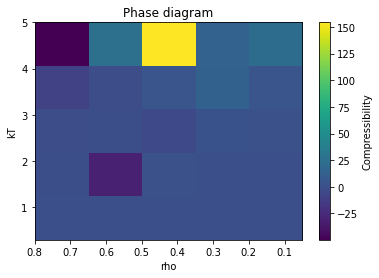

In [35]:
#Test of the speed-up
init_time = time.perf_counter()

compressibility = main(
    d,NParticles,sigma,epsilon,kT,rho,method='Compressibility')
#Save it to a .npy file
#np.save('compressibility.npy',compressibility)

print('Time to execute : ',time.perf_counter()-init_time)

Avec la parallelisation, nous gagnons un facteur deux en temps de calcul (sur ma machine). Cela va nous permettre d'une part d'effectuer de plus longues simulations afin de tester l'influence du retour à l'état d'équilibre du système. D'autre part, cette optimisation nous permet d'obtenir des diagrammes de phase plus résolu que (5x5)

In [36]:
#To change the length of the calculus please change the line 42 in main() : run_time = 100. * tau

**L'ensemble des résultats suivants ont été préalablement calculé sur les machines multi-coeur du Centre Blaise Pascal (192 coeurs) afin de réduire le temps de calcul.**

Text(0.5, 1.0, 'Phase diagram')

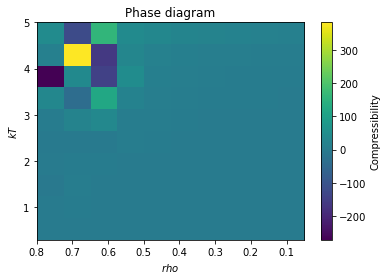

In [37]:
#Compressibility calculated on a 5x5 grid during run_time = 10000 * tau
compressibility = np.load('t10000_5x5/compressibility.npy')
plt.imshow(compressibility,extent=(0.8,0.05,0.3,5),aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Compressibility')
plt.xlabel('$rho$')
plt.ylabel('$kT$')
plt.title('Phase diagram')
#plt.savefig('phase_diagramm.png')

Les résultats, bien que nous ayons augmenté d'un facteur 100 le temps laissé à la simulation et augmenté la résolution de notre diagramme de phase, ne sont pas physiquement satisfaisant. Nous continuons de trouver des points avec une compressibilité bien supérieure à leurs voisins.

La compressibilité ne semble alors plus une grandeur de choix pour estimer la phase du système. Nous avons donc abandonné cette grandeur au profit du Déplacement Moyen Carré, *Mean Square Displacement, MSD*.

## Mean Square Displacement, MSD

### Trajectoire unique

Nous avons déjà implémenté, par simplicité, le calcul de MSD dans les fonctions de routine `main()` et `get_results()`. Nous effectuons de nouveaux nos calculs sur une grille (25x25) sur les ordinateurs multi-coeur du CBP avec `run_time = 500 * tau`.

In [38]:
#Uncomment this code to run it, otherwhise, results are given in the next cell


##Get MSD
#msd = main(
#    d,NParticles,sigma,epsilon,kT,rho,method='MSD')
##Save it to a .npy file
#np.save('msd.npy',msd)

Text(0.5, 1.0, 'Phase diagram')

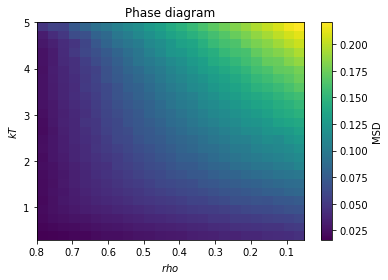

In [39]:
msd = np.load('msd_t500_25x25/msd.npy')
plt.imshow(msd,extent=(0.8,0.05,0.3,5),aspect='auto')
cbar = plt.colorbar()
cbar.set_label('MSD')
plt.xlabel('$rho$')
plt.ylabel('$kT$')
plt.title('Phase diagram')
#plt.savefig('phase_diagramm.png')

Ce résultats est obtenue en ~10 min sur la machine `platinum1` du CBP possédant 192 coeurs.

Nous obtenons des résulats physiquement convainquants cette fois-ci. En effet, nous observons que le déplacement moyen carré augmente effectivement avec la température et diminue avec la densité. Les zones les plus claires sont ainsi les zones en phase liquide. Les zones les plus foncées sont donc les zones en phase solide du système. 

Afin de départager les phases solides de liquides,nous pouvons concidérer que le système est solide si il prossède un MSD <= 0.050. Effectivement avec un tel deplacement moyen carré, l'échelle de déplacement des particules est inférieure à leur propre taille, définissant ainsi un solide. On observe toujours des vibrations des particules dans le solide.

### Estimation de l'erreur *via* un ensemble de trajectoires indépendantes

Afin de founir une estimation de l'erreur commise sur nos résultats, nous avons implémenté dans les fonctions de routine parallelisé la possibilité d'obtenir des résultats générés à partir d'un ensemble de trajectoires indépendantes. Pour cela nous utilisons les paramètres `ensemble` et `NTrajectories` des fonctions de routine.

Les résultats présentés ont été obtenues sur un ensemble de 10 trajectoires indépendantes de 16 particules chacune, `run_time = 200 * tau` et sur un diagramme de phase de (10x10) points.

In [40]:
#Uncomment this code to run it, otherwhise, results are given in the next cell

##Number of independant trajectories
#NTajectories = 10

##(10x10) phase diagram
kT = np.linspace(0.3,1,10)
rho  = np.linspace(0.05,0.8,10)/sigma**d

#Get MSD
#msd_mean , msd_std = main(
#    d,NParticles,sigma,epsilon,kT,rho,method='MSD',ensemble=True,NTrajectories=NTrajectories)

##Save it to a .npy file
#np.save('msd_mean.npy',msd_mean)
#np.save('msd_std.npy',msd_std)

Text(0.5, 1.0, 'Phase diagram')

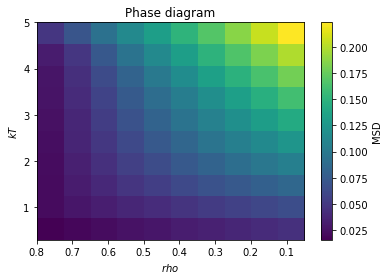

In [41]:
msd_mean = np.load('msd_ens_t200_10x10_ens10/msd_mean.npy')
msd_std = np.load('msd_ens_t200_10x10_ens10/msd_std.npy')/np.sqrt(10)

plt.imshow(msd_mean,extent=(0.8,0.05,0.3,5),aspect='auto')
cbar = plt.colorbar()
cbar.set_label('MSD')
plt.xlabel('$rho$')
plt.ylabel('$kT$')
plt.title('Phase diagram')
#plt.savefig('phase_diagramm.png')


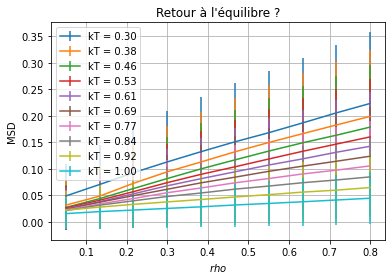

In [42]:
for i , kT_i in enumerate(msd_mean):
    plt.errorbar(rho,msd_mean[i,:],yerr=msd_std[i,:],label='kT = {:.2f}'.format(kT[i]))
    
plt.xlabel('$rho$')
plt.ylabel('MSD')
plt.title("Retour à l'équilibre ?")
plt.legend()
plt.grid()

Ce résultat a été obtenu en ~15min sur la machine `epyc3`, 256 coeurs, du CBP. Nous constatons que les barre d'erreur sont trop grandes pour être suffisement satisfaisantes. Nous lançons donc le même programme en augmentant le temps de simulation : `run_time = 500*tau` et en diminuant le nombre de trajectoires pour réduire le temps de calcul : `NTrajectories = 5`

Text(0.5, 1.0, 'Phase diagram')

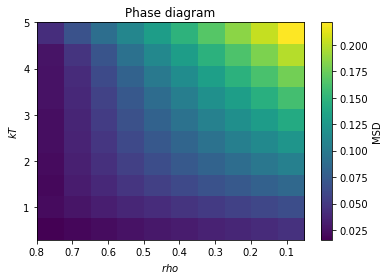

In [43]:
msd_mean = np.load('msd_ens_t500_10x10_ens5/msd_mean.npy')
msd_std = np.load('msd_ens_t500_10x10_ens5/msd_std.npy')/np.sqrt(5)

plt.imshow(msd_mean,extent=(0.8,0.05,0.3,5),aspect='auto')
cbar = plt.colorbar()
cbar.set_label('MSD')
plt.xlabel('$rho$')
plt.ylabel('$kT$')
plt.title('Phase diagram')
#plt.savefig('phase_diagramm.png')

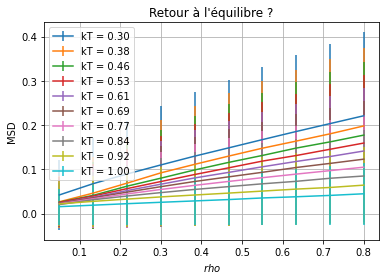

In [44]:
for i , kT_i in enumerate(msd_mean):
    plt.errorbar(rho,msd_mean[i,:],yerr=msd_std[i,:],label='kT = {:.2f}'.format(kT[i]))
    
plt.xlabel('$rho$')
plt.ylabel('MSD')
plt.title("Retour à l'équilibre ?")
plt.legend()
plt.grid()

Ce résultat est obtenue en ~1h30 sur la même machine. Par manque de temps dans la réalisation de ce projet, nous n'avons pas pu lancer plus de calcul afin de réduire les barres d'erreur.

## Conclusion

Nous avons ainsi optimisé l'automatisation de l'exploration du diagramme de phase du système de Lennard-Jones. Cette optimisation a été réalisé par la parallelisation des taches effectuées. 

Nos résultats, prométeurs, sont physiquement cohérents lorsque ces derniers reposent sur le MSD. Il reste cependant une erreur importante dans nos résultats. Ces erreurs peuvent être réduites en augmentant le temps de calcul et le nombre de trajectoires indépendantes générées; des temps de calculs plus long sont donc à prévoir pour un tel projet. Une méthode alternative pour estimer l'erreur associée à nos calculs serait d'explorer le diagramme de phase de différentes manière : en diminuant la température, en diminuant la densité... Cela peut-être aiséement mis en place dans nos fonctions de routine avec la méthode `np.flip`. Ces tests ont été effectués mais non présenté dans ce rapport car beaucoup d'entre eux n'ont pas eu le temps de connverger.

Aussi, nous avons implémenté dans nos fonctions de routine la possibilité d'obtenir un diagramme de phase reposant non pas sur le MSD ou la compressibilité mais sur la pression. Au vu de peu de temps à notre disposition pour ce projet nous avons préféré ne pas détailler les calculs de cette grandeurs. Cette grandeur peux aussi être étudié dans l'optique d'une fortification de nos résulats.